#Аннотированный S4
##[Эффективное моделирование длинных последовательностей с помощью структурированных пространств состояний](https://arxiv.org/abs/2111.00396)

$\text{Альберт Гу, Каран Гоэл и Кристофер Ре}$

$\text{перевод и адаптация Роман Перепелкин}$

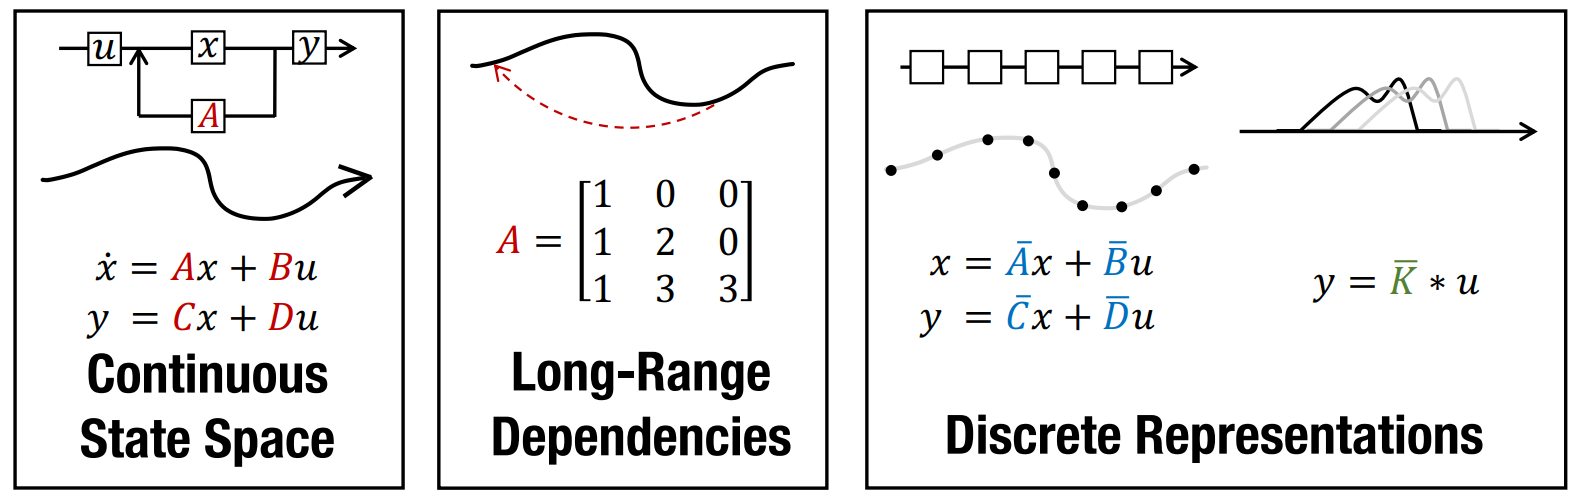

Сообщение в блоге и [библиотека](https://github.com/srush/annotated-s4/) [Саши Раша](https://rush-nlp.com/) и [Сидда Карамчети](https://www.siddkaramcheti.com/) , версия 3

Архитектура [Структурированного пространства состояний для моделирования последовательностей](https://arxiv.org/abs/2111.00396) (S4) — это новый подход к задачам моделирования последовательностей очень дальнего действия для зрения, языка и звука, демонстрирующий способность фиксировать зависимости на протяжении десятков тысяч шагов. Особенно впечатляют результаты модели в сложном тесте [Long Range Arena](https://github.com/google-research/long-range-arena), демонстрирующие способность с высокой точностью анализировать последовательности, содержащие до 16 000+ элементов.

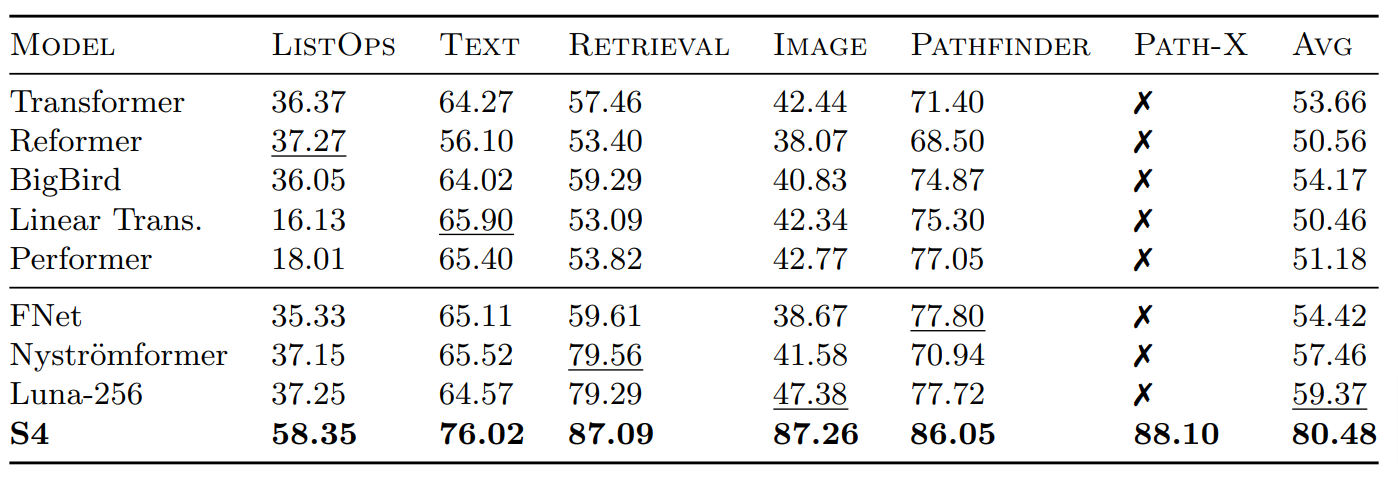

Эта статья также представляет собой освежающий отход от «Трансформеров», в котором используется совершенно иной подход к важному проблемному пространству. Однако некоторые из наших коллег в частном порядке также отметили сложность интуитивного понимания модели. Эта запись в блоге является первым шагом на пути к достижению этой цели — обретению интуиции, связыванию конкретных реализаций кода с объяснениями из статьи S4 — очень в стиле [аннотированного Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html) . Надеемся, такое сочетание кода и грамотных объяснений поможет вам уследить за деталями модели. К концу блога у вас будет эффективная рабочая версия S4, которая может работать как CNN для обучения, но затем конвертироваться в эффективную RNN во время тестирования. Для предварительного просмотра результатов вы сможете генерировать изображения из пикселей и звуки непосредственно из звуковых волн на стандартном графическом процессоре.

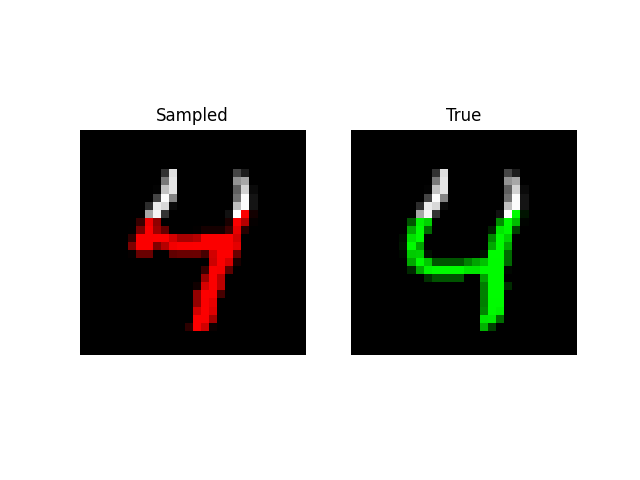

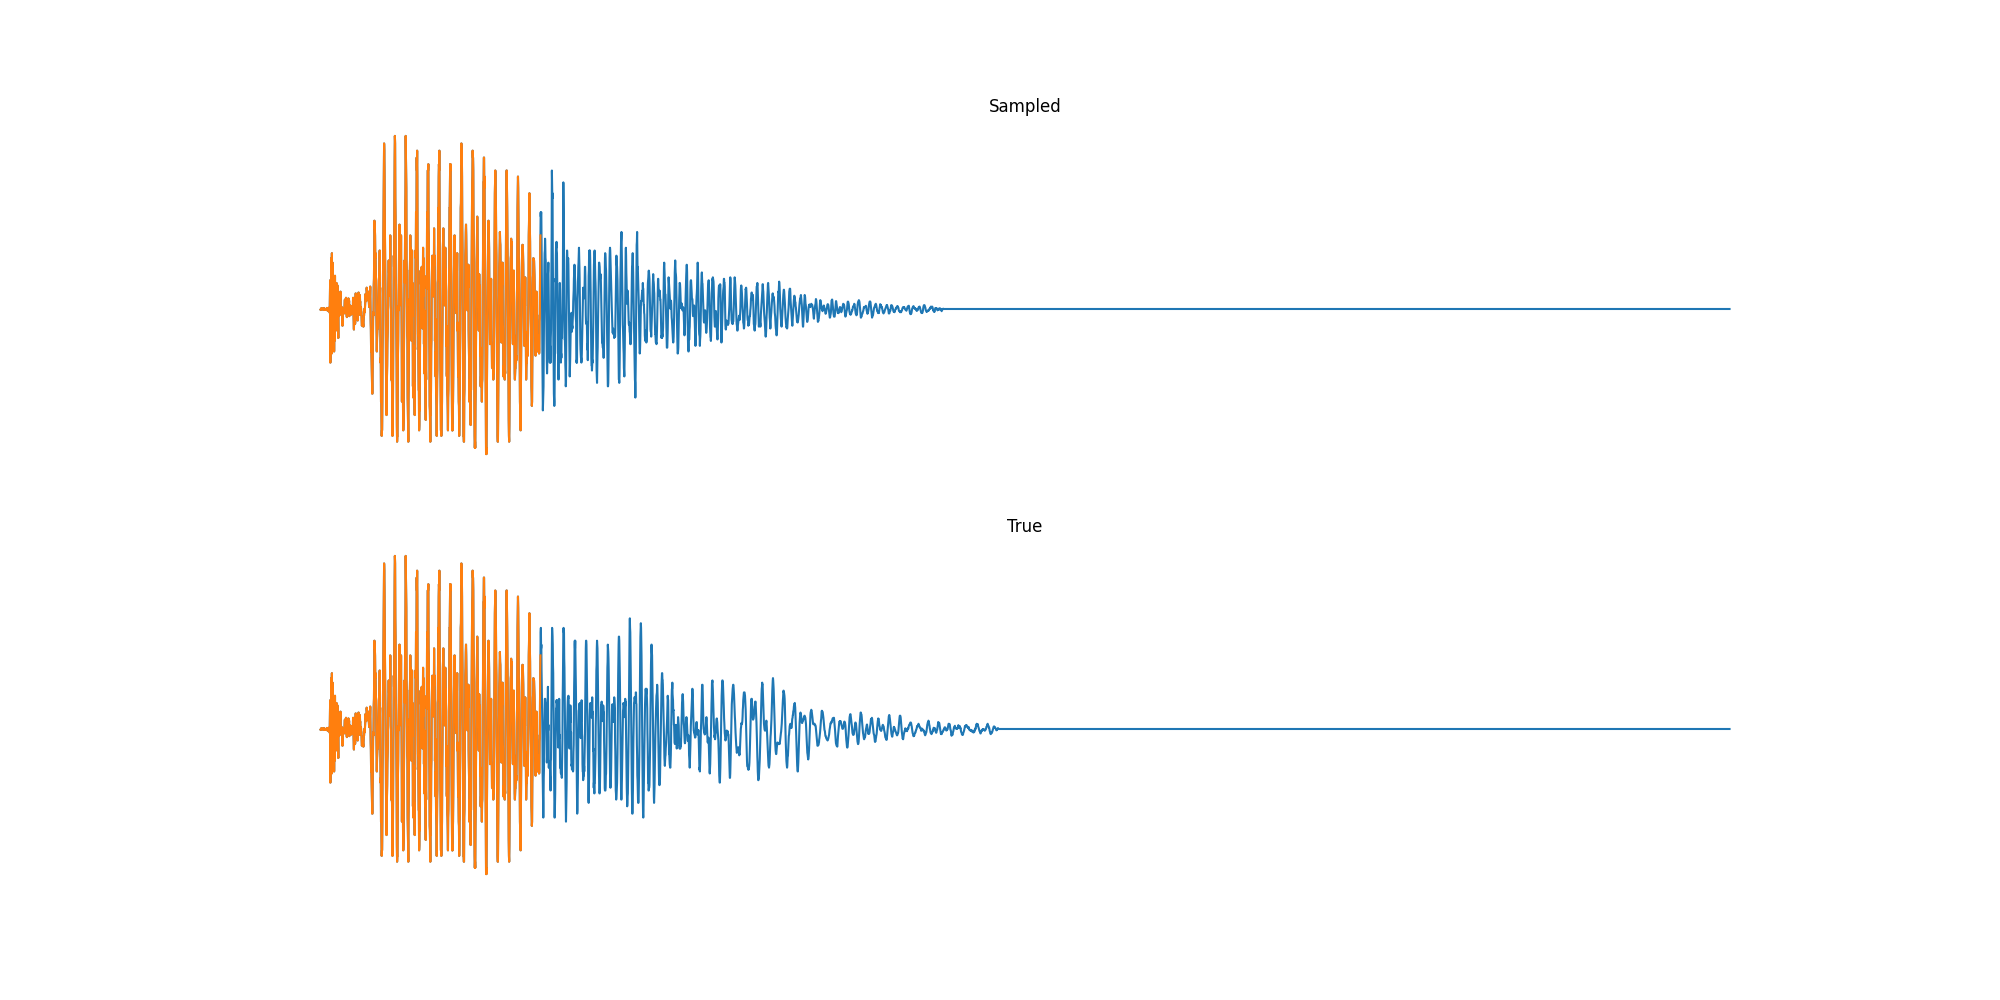

In [ ]:
from IPython.display import Audio
sound_file = 'https://srush.github.io/annotated-s4/images/sample25.0.wav'
Audio(sound_file, autoplay=True)

# Оглавление
* Часть 1. Модели пространства состояний (моделирование)
  * SSM дискретного времени: рекуррентное представление
  * Касательная: пример механики
  * Обучение SSM: сверточное представление
  * Нейронная сеть SSM.
* Часть 1b. Устранение долгосрочных зависимостей с помощью HiPPO
* Часть 2. Реализация S4 (расширенный уровень)
  * Шаг 1. Генерирующие функции SSM
  * Шаг 2: Диагональный случай
  * Шаг 3: Диагональ плюс низкий ранг
  * Диагональ плюс RNN низкого ранга.
  * Превращение HiPPO в DPLR
  * Окончательная проверка
* Часть 3: S4 на практике (реализация NN)
  * S4 Уровень CNN/RNN
  * Выборка и кэширование
  * Эксперименты: МНИСТ
  * Эксперименты: QuickDraw
  * Эксперименты: произнесение цифр
* Заключение


Обратите внимание, что в этом проекте используется [JAX](https://github.com/google/jax/) с библиотекой [Flax](https://github.com/google/flax) NN. Хотя мы лично в основном используем Torch, функциональная природа JAX хорошо подходит для некоторых сложностей S4. Мы активно используем [vmap , scan](https://jax.readthedocs.io/en/latest/jax.html#jax.vmap), и, самое главное, [jax.jit](https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html#jit-mechanics-tracing-and-static-variables) для быстрой и эффективной компиляции слоев S4.

In [ ]:
from functools import partial
import jax
import jax.numpy as np
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

In [ ]:
!pip install celluloid

In [ ]:
if __name__ == "__main__":
    # For this tutorial, construct a global JAX rng key
    # But we don't want it when importing as a library
    rng = jax.random.PRNGKey(1)
    print(rng)

[0 1]


# Часть 1: Модель простанства состояний
---
Давайте начнем! Наша цель — эффективное моделирование длинных последовательностей. Для этого мы собираемся построить новый слой нейронной сети на основе моделей пространства состояний. К концу этого раздела мы сможем построить и запустить модель с этим слоем. Однако нам понадобится некоторая техническая подготовка. Давайте пройдемся по основам из статьи.

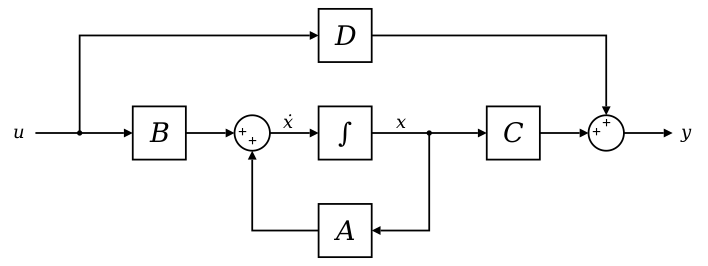


>Модель пространства состояний определяется этим простым уравнением. Она отображает $1$-D входной сигнал $u(t)$ в $N$-D скрытое состояние $x(t)$ перед проецированием в $1$-D выходной сигнал $y(t)$.
$$x'(t) = Аx(t) + Bu(t)\\
y(t) = Cx(t) + Du(t) $$
<br>
Наша цель — просто использовать SSM как представление «черного ящика» в модели глубокой последовательности, где $A, B, C, D$ — это параметры, получаемые методом градиентного спуска.
<br>
В заключении, мы опустим параметр $D$ (что эквиватентно предположению о том, что $D = 0$, т.к. $Du$ можно рассматривать как $skip-connection$, и его легко вычислить)
<br><br>
SSM отображает вход $u(t)$ на вектор представления состояния $x(t)$ и на выход $y(t)$.
<br><br>
Для простоты мы предполагаем, что входные и выходные данные одномерны, а представление состояния имеет $N$-мерный вид.
Первое уравнение определяет изменение $x(t)$ во времени.

Наши SSM будут определяться тремя матрицами $A,B,C$ – чему мы и научимся. На данный момент мы начинаем со случайного SSM, чтобы определить размеры...

In [ ]:
def random_SSM(rng, N):
    a_r, b_r, c_r = jax.random.split(rng, 3)
    A = jax.random.uniform(a_r, (N, N))
    B = jax.random.uniform(b_r, (N, 1))
    C = jax.random.uniform(c_r, (1, N))
    return A, B, C
HIDDEN_DIM = 8
A, B, C = random_SSM(rng, HIDDEN_DIM)
print('A: ', A)
print('B: ', B)
print('C: ', C)

NameError: name 'rng' is not defined

# Дискретизация SSM во времени: Рекурентное представление
---

>Применяется к дискретной входной последовательности $(u0, u1, ...)$ вместо непрерывной функции $u(t)$,  SSM должена быть дискретизирована на размер шага $Δ$, который представляет разрешение входа. Концептуально входные данные $u_k$ можно рассматривать как выборку неявного основного непрерывного сигнала $u(t)$, где $u_k = u(k_Δ)$.
<br><br>
Для дискретизации непрерывного времени SSM мы используем билинейный метод, который преобразует матрицу состояний $A$ в приближение $\overline{A}$.
Дискретная SSM – это:
<br><br>
$$
\overline{A} = (I - Δ/2 * A)^{-1}(I +Δ/2 * A)\\
\overline{B} = (I - Δ/2 * A)^{-1}ΔB\\
\overline{C} = C
$$


In [ ]:
def discretize(A, B, Cc, step):
    I = np.eye(A.shape[0])
    print('I: ', I)
    BL = inv(I - (step / 2.0) * A)
    Ab = BL @ (I + (step / 2.0) * A)
    Bb = (BL * step) @ B
    return Ab, Bb, Cc
step = 1

Ab, Bb, C = discretize(A, B, C, step)
print('Ab: ', Ab)
print('Bb: ', Bb)
print('C: ', C)

I:  [[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
Ab:  [[ 0.72057116  0.12091296 -0.13538456 -0.6478471  -0.7532242  -0.7134415
  -0.69494295 -0.04767586]
 [-0.10731398  0.58345556 -1.3015704  -0.28428042 -0.2082666  -0.617631
  -1.2452949  -0.9116561 ]
 [-1.1508825  -1.1859117   1.1238499  -0.90370494 -0.7620372   0.17285998
   0.27323872 -0.47235858]
 [ 0.6781963   0.42125377 -1.0138965   0.762488   -0.43778092 -1.1591263
  -1.0947462  -0.6578319 ]
 [ 0.10530412 -0.58361536 -0.8296143   0.1854922   0.6456679  -0.46588656
  -0.53322935 -0.9412961 ]
 [-0.89669824 -1.0073453  -0.00721575 -0.64149666 -0.07273141  0.7957789
  -0.177857   -0.49280676]
 [-0.95150435 -0.91093135 -0.8193476  -0.35069782 -0.15431261 -0.40465873
   0.32357943 -0.9614676 ]
 [-0.0985678   0.42269498 -1.2752717  -0.23484895 -0.65427625 -1.000868


>Это уравнение теперь представляет собой отображение последовательности в последовательность $u_k \to y_k$ вместо функции к функции. Более того, уравнение состояния теперь является рекурсией $x_k$, что позволяет вычислять дискретный SSM как RNN. Конкретно, $x_k \in \mathbb{R}^N$ можно рассматривать как скрытое состояние с матрицей перехода $\overline{A}$;
<br><br>
$$
x_k = \overline{A}x_{k-1} + \overline{B}u_k\\
y_k = \overline{C}x_k
$$

«Cтупенчатая» функция внешне похожа на функцию RNN. Мы можем реализовать это с помощью сканирования

In [ ]:
def scan_SSM(Ab, Bb, Cb, u, x0):
    def step(x_k_1, u_k):
        x_k = Ab @ x_k_1 + Bb @ u_k
        y_k = Cb @ x_k
        return x_k, y_k

    return jax.lax.scan(step, x0, u)

Собрав все вместе, мы можем запустить SSM, сначала дискретизируя, а затем итерируя шаг за шагом.

In [ ]:
def run_SSM(A, B, C, u):
    L = u.shape[0]
    N = A.shape[0]
    Ab, Bb, Cb = discretize(A, B, C, step=1.0 / L)

    # Run recurrence
    return scan_SSM(Ab, Bb, Cb, u[:, np.newaxis], np.zeros((N,)))[1]

# Касательная: пример из механики
___
Чтобы получить больше интуиции и протестировать нашу реализацию SSM, реализуем классический пример из механики .

В этом примере мы рассматриваем переднюю позицию $y(t)$ массы, прикрепленной к стене с помощью пружины.
С течением времени меняющаяся сила $u(t)$ применяется к этой массе. Система параметризуется массой $(m)$, пружинная константа $(k)$, константа трения $(b)$.
Мы можем связать их с помощью следующего дифференциального уравнения:
$$
\ \\
my''(t) = u(t) - by'(t) - ky(t)
\\
$$

Переписав это в матричной форме, получим SSM в следующей форме:

$$
A = \begin{bmatrix}
       \ 0 & 1 \\
       -k/m           & -b/m
     \end{bmatrix}\\
B = \begin{bmatrix}
       \ 0\\
       1/m
     \end{bmatrix}\\
C = \begin{bmatrix}
       \ 1 & 0
     \end{bmatrix}
$$



In [ ]:
def example_mass(k, b, m):
    A = np.array([[0, 1], [-k / m, -b / m]])
    B = np.array([[0], [1.0 / m]])
    C = np.array([[1.0, 0]])
    return A, B, C

Глядя на $С$, мы должны быть в состоянии убедить себя, что первое измерение скрытого состояния — это позиция (поскольку она становится $y(t)$). Второе измерение — это скорость, поскольку на него влияет $u(t)$ через $B$, с которым связан $A$.

Мы установим $u$ как непрерывную функцию от $t$


In [ ]:
@partial(np.vectorize, signature="()->()")
def example_force(t):
    x = np.sin(10 * t)
    return x * (x > 0.5)

Давайте запустим этот SSM через наш код.

In [ ]:
def example_ssm():
    # SSM
    ssm = example_mass(k=40, b=5, m=1)
    # L samples of u(t).
    L = 100
    step = 1.0 / L
    ks = np.arange(L)
    u = example_force(ks * step)

    # Approximation of y(t).
    y = run_SSM(*ssm, u)

    # Plotting ---
    import matplotlib.pyplot as plt
    import seaborn
    from celluloid import Camera

    seaborn.set_context("paper")
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    camera = Camera(fig)
    ax1.set_title("Force $u_k$")
    ax2.set_title("Position $y_k$")
    ax3.set_title("Object")
    ax1.set_xticks([], [])
    ax2.set_xticks([], [])

    # Animate plot over time
    for k in range(0, L, 2):
        ax1.plot(ks[:k], u[:k], color="red")
        ax2.plot(ks[:k], y[:k], color="blue")
        ax3.boxplot(
            [[y[k, 0] - 0.04, y[k, 0], y[k, 0] + 0.04]],
            showcaps=False,
            whis=False,
            vert=False,
            widths=10,
        )
        camera.snap()
    anim = camera.animate()
    anim.save("line.gif", dpi=150, writer="imagemagick")

In [ ]:
example_ssm()

Красиво! И это была лишь 1 SSM с двумя скрытыми состояниями на протяжении более 100 шагов. Окончательная модель будет содержать сотни SSM, идущие друг за другом и состоящие из тысяч шагов . Но сначала нам нужно сделать эти модели практичными для обучения.

#Обучение SSM: сверточное представление
---
Изюминка этого раздела заключается в том, что мы можем превратить приведенную выше «RNN» в «CNN», развернув ее. Пройдемся по выводу.

>Повторяющийся SSM непрактичен для обучения на современном оборудовании из-за его последовательного характера. Вместо этого существует хорошо известная связь между линейными стационарными (LTI) SSM и непрерывными свертками. Соответственно, рекуррентную SSM фактически можно записать в виде дискретной свертки.
<br><br>
Для простоты пусть начальное состояние будет $x_{-1} = 0$.
Тогда развертывание явно дает:
<br><br>
$$
x_0 = \overline{B}u_0\ \ \ \ x_1 = \overline{A}\overline{B}u_0+\overline{B}u_1\ \ \ \ x_2 = \overline{A}^2\overline{B}u_0+\overline{A}\overline{B}u_1+\overline{B}u_2\ \ \ \ ...\\
y_0 = \overline{C}\overline{B}u_0\ \ \ \ y_1 = \overline{C}\overline{A}\overline{B}u_0+\overline{C}\overline{B}u_1\ \ \ \ y_2 = \overline{C}\overline{A}^2\overline{B}u_0+\overline{C}\overline{A}\overline{B}u_1+\overline{C}\overline{B}u_2\ \ \ \ ...$$
<br>
Это можно векторизовать в свертку с явной формулой для ядра свертки.
<br>
$$
y_k = \overline{C}\overline{A}^k\overline{B}u_0+\overline{C}\overline{A}^{k-1}\overline{B}u_1+...+\overline{C}\overline{A}\overline{B}u_{k-1}+\overline{C}\overline{B}u_k\\
y=\overline{K} * u\\
\text{где }\overline{K} \in \mathbb{R}^L = (\overline{C}\overline{B}, \overline{C}\overline{A}\overline{B},...,\overline{C}\overline{A}^{L-1}\overline{B})$$

Назовем $\overline{K}$; ядром или свертки (или фильтром) SSM .

Обратите внимание, что это гигантский фильтр. Он равен размеру всей последовательности!

In [ ]:
def K_conv(Ab, Bb, Cb, L):
    return np.array(
        [(Cb @ matrix_power(Ab, l) @ Bb).reshape() for l in range(L)]
    )

Внимание: эта реализация наивная и нестабильная. На практике это не сработает на более чем очень малых длинах. Однако мы собираемся заменить его на S4 во второй части, поэтому пока оставим его в качестве примера.

Мы можем вычислить результат применения этого фильтра либо с помощью стандартной прямой свертки, либо с помощью теоремы о свертке с [быстрым преобразованием Фурье](https://en.wikipedia.org/wiki/Convolution_theorem) (БПФ) . Теорема дискретной свертки — для круговой свертки двух последовательностей — позволяет нам эффективно вычислить результат свертки, сначала умножая БПФ входных последовательностей, а затем применяя обратное БПФ. Чтобы использовать эту теорему для некруговых сверток, как в нашем случае, нам нужно дополнить входные последовательности нулями, а затем отменить дополнение выходной последовательности. По мере увеличения длины этот метод БПФ будет более эффективным, чем прямая свертка.

In [ ]:
def causal_convolution(u, K, nofft=False):
    if nofft:
        return convolve(u, K, mode="full")[: u.shape[0]]
    else:
        assert K.shape[0] == u.shape[0]
        ud = np.fft.rfft(np.pad(u, (0, K.shape[0])))
        Kd = np.fft.rfft(np.pad(K, (0, u.shape[0])))
        out = ud * Kd
        return np.fft.irfft(out)[: u.shape[0]]

Метод CNN и метод RNN дают (примерно) один и тот же результат:

In [ ]:
def test_cnn_is_rnn(N=4, L=16, step=1.0 / 16):
    ssm = random_SSM(rng, N)
    u = jax.random.uniform(rng, (L,))
    jax.random.split(rng, 3)
    # RNN
    rec = run_SSM(*ssm, u)

    # CNN
    ssmb = discretize(*ssm, step=step)
    conv = causal_convolution(u, K_conv(*ssmb, L))

    # Check
    assert np.allclose(rec.ravel(), conv.ravel())

# Нейронная сеть SSM.
---
Теперь у нас есть все необходимое для создания базового слоя нейронной сети SSM. Как определено выше, дискретный SSM определяет карту из $\mathbb{R}^L→\mathbb{R}^L$, то есть одномерная ($1$-D) карта последовательности. Мы предполагаем, что собираемся изучить параметры $B$ и $C$, а также размер шага $Δ$ и скалярный параметр $D$. Матрица HiPPO используется для перехода $А$. Мы узнаем размер шага в пространстве журнала.

In [ ]:
def log_step_initializer(dt_min=0.001, dt_max=0.1):
    def init(key, shape):
        return jax.random.uniform(key, shape) * (
            np.log(dt_max) - np.log(dt_min)
        ) + np.log(dt_min)

    return init

На уровне SSM большая часть работы заключается в построении фильтра. Фактический вызов сети — это всего лишь (огромная) свертка, которую мы указали выше.

Примечание для пользователей Torch: $setup$ в $Flax$ вызывается каждый раз при обновлении параметров. Это похоже на [параметризацию Torch](https://pytorch.org/tutorials/intermediate/parametrizations.html).

Как отмечалось выше, этот же уровень можно использовать как RNN, так и CNN. Аргумент $decode$ определяет, какой путь используется. В случае RNN мы кэшируем предыдущее состояние при каждом вызове коллекции переменных $Flax$ под названием $cache$.

In [ ]:
class SSMLayer(nn.Module):
    N: int
    l_max: int
    decode: bool = False

    def setup(self):
        # SSM parameters
        self.A = self.param("A", lecun_normal(), (self.N, self.N))
        self.B = self.param("B", lecun_normal(), (self.N, 1))
        self.C = self.param("C", lecun_normal(), (1, self.N))
        self.D = self.param("D", nn.initializers.ones, (1,))

        # Step parameter
        self.log_step = self.param("log_step", log_step_initializer(), (1,))

        step = np.exp(self.log_step)
        self.ssm = discretize(self.A, self.B, self.C, step=step)
        self.K = K_conv(*self.ssm, self.l_max)

        # RNN cache for long sequences
        self.x_k_1 = self.variable("cache", "cache_x_k", np.zeros, (self.N,))

    def __call__(self, u):
        if not self.decode:
            # CNN Mode
            return causal_convolution(u, self.K) + self.D * u
        else:
            # RNN Mode
            x_k, y_s = scan_SSM(*self.ssm, u[:, np.newaxis], self.x_k_1.value)
            if self.is_mutable_collection("cache"):
                self.x_k_1.value = x_k
            return y_s.reshape(-1).real + self.D * u

Поскольку наши SSM работают со скалярами, мы делаем $H$ разные, сложенные друг на друга копии ($H$ разные SSM!) с разными параметрами. Здесь мы используем метод [$Flax$ $vmap$](https://flax.readthedocs.io/en/latest/api_reference/flax.linen/_autosummary/flax.linen.vmap.html) , чтобы легко определить эти копии:

In [ ]:
def cloneLayer(layer):
    return nn.vmap(
        layer,
        in_axes=1,
        out_axes=1,
        variable_axes={"params": 1, "cache": 1, "prime": 1},
        split_rngs={"params": True},
    )

In [ ]:
SSMLayer = cloneLayer(SSMLayer)

Этот уровень SSM затем можно поместить в стандартную NN. Здесь мы добавляем блок, который объединяет вызов SSM с отсевом и линейной проекцией.

In [ ]:
class SequenceBlock(nn.Module):
    layer_cls: nn.Module
    layer: dict  # Hyperparameters of inner layer
    dropout: float
    d_model: int
    prenorm: bool = True
    glu: bool = True
    training: bool = True
    decode: bool = False

    def setup(self):
        self.seq = self.layer_cls(**self.layer, decode=self.decode)
        self.norm = nn.LayerNorm()
        self.out = nn.Dense(self.d_model)
        if self.glu:
            self.out2 = nn.Dense(self.d_model)
        self.drop = nn.Dropout(
            self.dropout,
            broadcast_dims=[0],
            deterministic=not self.training,
        )

    def __call__(self, x):
        skip = x
        if self.prenorm:
            x = self.norm(x)
        x = self.seq(x)
        x = self.drop(nn.gelu(x))
        if self.glu:
            x = self.out(x) * jax.nn.sigmoid(self.out2(x))
        else:
            x = self.out(x)
        x = skip + self.drop(x)
        if not self.prenorm:
            x = self.norm(x)
        return x

Затем мы можем сложить кучу этих блоков друг на друга, чтобы создать стопку слоев SSM. Его можно использовать для классификации или генерации стандартным способом в качестве преобразователя.

In [ ]:
class Embedding(nn.Embed):
    num_embeddings: int
    features: int

    @nn.compact
    def __call__(self, x):
        y = nn.Embed(self.num_embeddings, self.features)(x[..., 0])
        return np.where(x > 0, y, 0.0)

In [ ]:
class StackedModel(nn.Module):
    layer_cls: nn.Module
    layer: dict  # Extra arguments to pass into layer constructor
    d_output: int
    d_model: int
    n_layers: int
    prenorm: bool = True
    dropout: float = 0.0
    embedding: bool = False  # Use nn.Embed instead of nn.Dense encoder
    classification: bool = False
    training: bool = True
    decode: bool = False  # Probably should be moved into layer_args

    def setup(self):
        if self.embedding:
            self.encoder = Embedding(self.d_output, self.d_model)
        else:
            self.encoder = nn.Dense(self.d_model)
        self.decoder = nn.Dense(self.d_output)
        self.layers = [
            SequenceBlock(
                layer_cls=self.layer_cls,
                layer=self.layer,
                prenorm=self.prenorm,
                d_model=self.d_model,
                dropout=self.dropout,
                training=self.training,
                decode=self.decode,
            )
            for _ in range(self.n_layers)
        ]

    def __call__(self, x):
        if not self.classification:
            if not self.embedding:
                x = x / 255.0  # Normalize
            if not self.decode:
                x = np.pad(x[:-1], [(1, 0), (0, 0)])
        x = self.encoder(x)
        for layer in self.layers:
            x = layer(x)
        if self.classification:
            x = np.mean(x, axis=0)
        x = self.decoder(x)
        return nn.log_softmax(x, axis=-1)

Во Flax мы добавляем пакетное измерение как расширенное преобразование. Нам нужно пройти через несколько коллекций переменных, которые обрабатывают RNN и кэширование параметров (описано ниже).

In [ ]:
BatchStackedModel = nn.vmap(
    StackedModel,
    in_axes=0,
    out_axes=0,
    variable_axes={"params": None, "dropout": None, "cache": 0, "prime": None},
    split_rngs={"params": False, "dropout": True},
)

В целом, это определяет карту формы последовательности-последовательности (размер партии, длина последовательности, скрытое измерение), то есть подпись, предоставляемую связанными моделями последовательностей, такими как трансформаторы, RNN и CNN.

Полный код обучения определен в файле [Training.py](https://github.com/srush/annotated-s4/blob/main/s4/train.py) .

Хотя теперь у нас есть основная модель, у SSM есть две основные проблемы . Во-первых, случайно инициализированный SSM на самом деле работает не очень хорошо. Более того, наивные вычисления, как мы делали до сих пор, очень медленны и неэффективны с использованием памяти. Далее мы завершим обсуждение аспекта моделирования S4, определив специальную инициализацию для долгосрочных зависимостей, а затем выясним, как вычислить этот уровень SSM быстрее — намного быстрее ( Часть 2 )!

# Часть 1b. Устранение долгосрочных зависимостей с помощью HiPPO
---
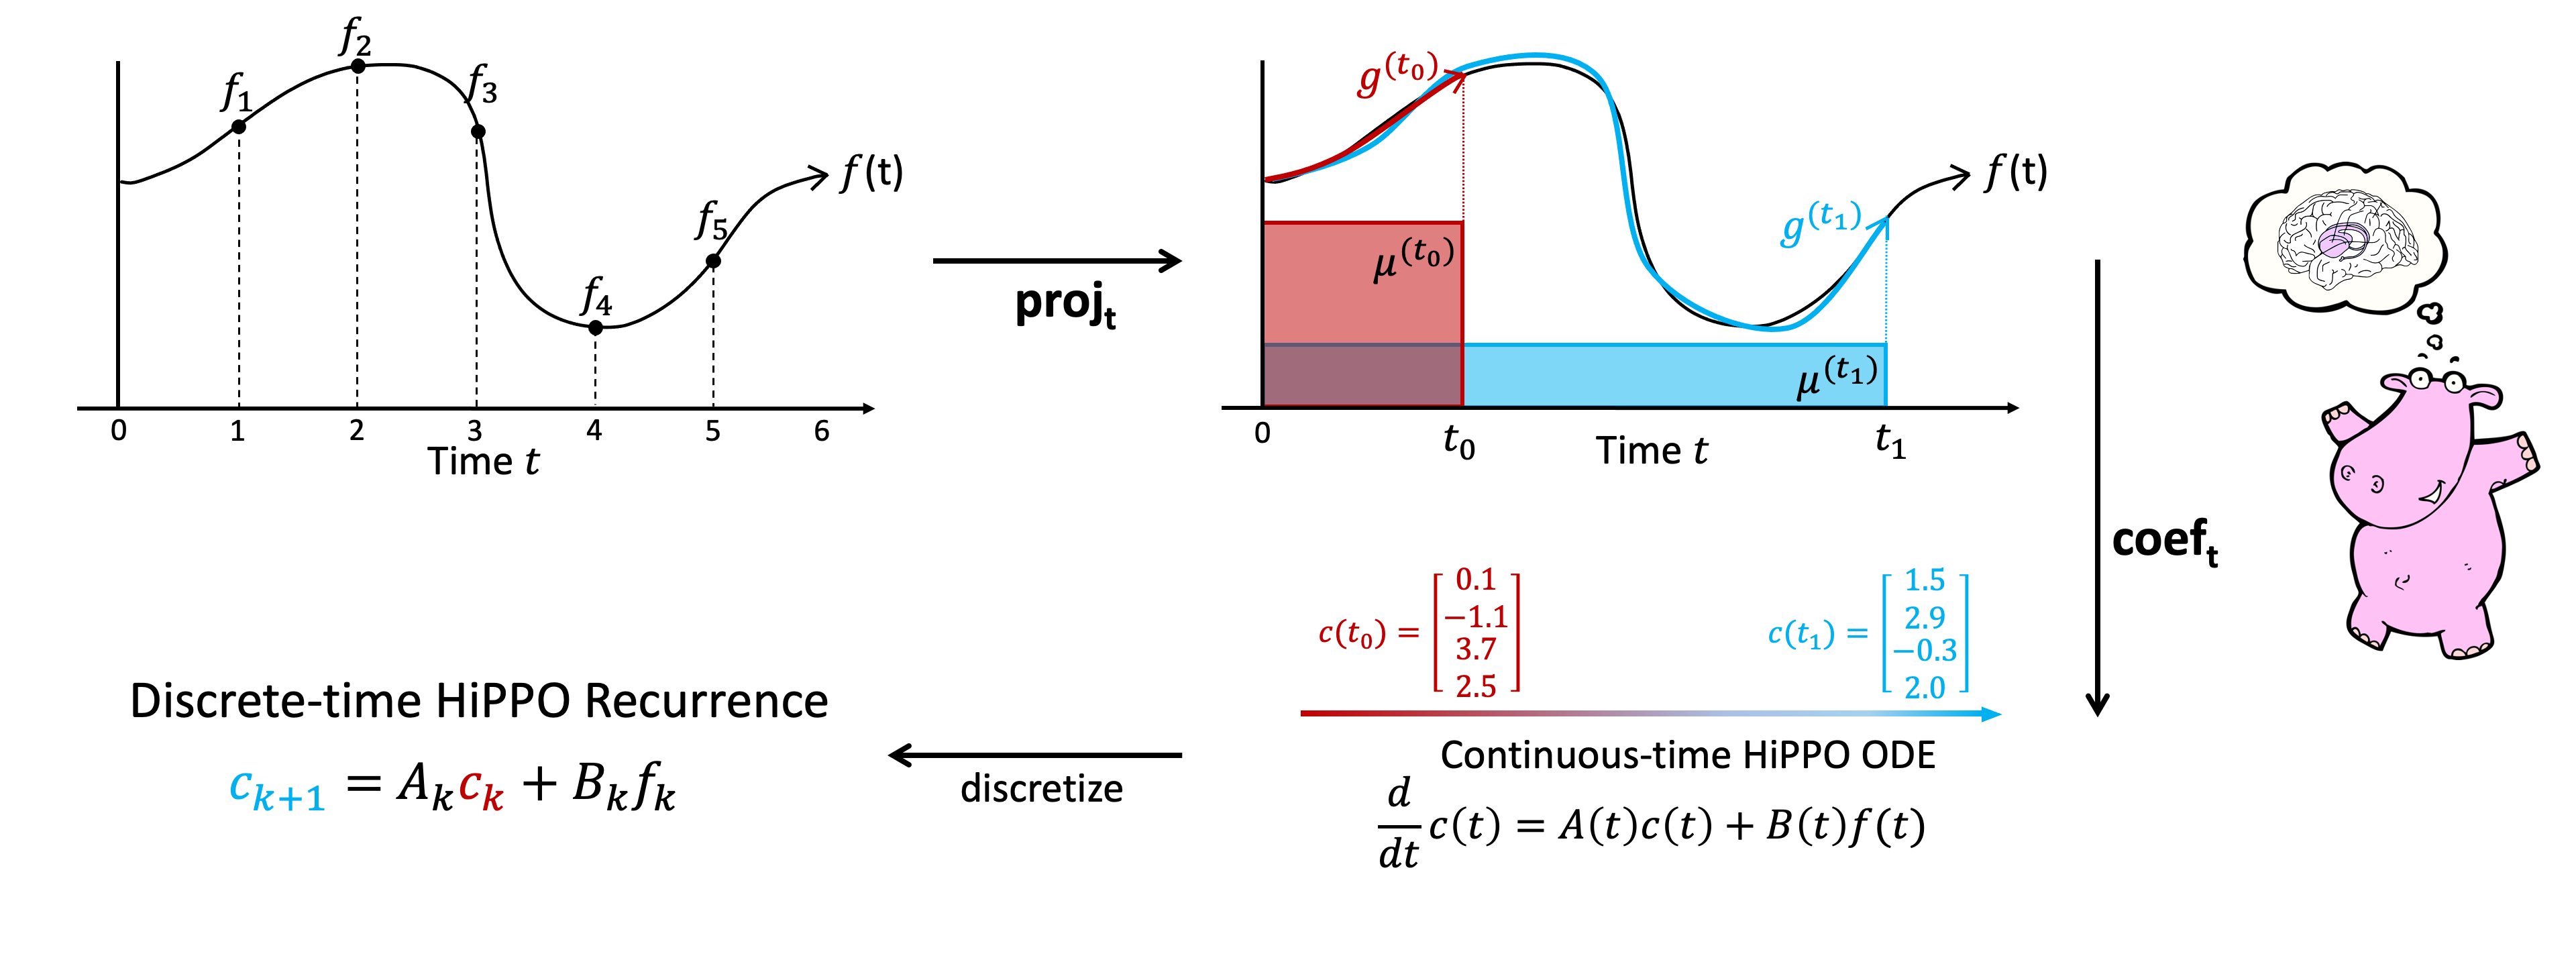

>[Предыдущие исследования](https://arxiv.org/abs/2008.07669) показали, что базовый SSM на практике работает очень плохо. Интуитивно понятно, что одно из объяснений заключается в том, что они страдают от экспоненциального масштабирования градиентов по длине последовательности (т. е. проблема исчезновения/взрыва градиентов). Для решения этой проблемы в предыдущей работе была разработана теория непрерывного запоминания HiPPO.<p>
HiPPO указывает класс определенных матриц $А \in \mathbb{R}^{Н×Н}$ что, будучи зарегистрированным, позволит скрытому состоянию $x(t)$ запомнить историю ввода $u(t)$.
Самая важная матрица в этом классе определяется матрицей HiPPO.<p>
$\text{(HiPPO Matrix)}\ \ \ \ A_{nk} = \left. \begin{cases} { (2n + 1)^{1/2}(2k+1)^{1/2} \ \ \ \ \text{ if } n>k} \\ { n+1   \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \text{ if } n=k} \\ {0\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \text{ if } n<k} \end{cases} \right.
$<p>
Предыдущая работа показала, что простая модификация SSM из случайной матрицы $А$ в HiPPO улучшила свои показатели в последовательном тесте классификации MNIST с 60% до 98%.

Эта матрица будет очень важной, но в ней есть немного волшебства. Для наших целей нам в основном нужно знать, что: 1) нам нужно вычислить его только один раз и 2) он имеет красивую и простую структуру (которую мы будем использовать в части 2). Не вдаваясь в математику ОДУ, основной вывод заключается в том, что эта матрица призвана сжать прошлую историю до состояния, в котором будет достаточно информации для приблизительной реконструкции истории.




In [ ]:
def make_HiPPO(N):
    P = np.sqrt(1 + 2 * np.arange(N))
    A = P[:, np.newaxis] * P[np.newaxis, :]
    A = np.tril(A) - np.diag(np.arange(N))
    return -A

Если копнуть немного глубже, интуитивное объяснение этой матрицы состоит в том, что она создает скрытое состояние, запоминающее свою историю. Это делается путем отслеживания коэффициентов полинома [Лежандра](https://en.wikipedia.org/wiki/Legendre_polynomials).
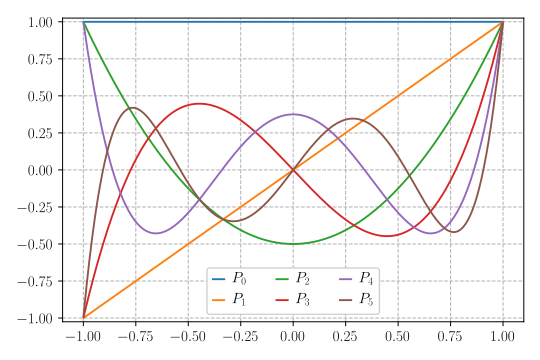

Эти коэффициенты позволяют аппроксимировать всю предыдущую историю. Давайте посмотрим на пример,

In [ ]:

def example_legendre(N=100):
    # Random hidden state as coefficients
    import numpy as np
    import numpy.polynomial.legendre

    x = (np.random.rand(N) - 0.5) * 2
    t = np.linspace(-1, 1, 100)
    f = numpy.polynomial.legendre.Legendre(x)(t)

    # Plot
    import matplotlib.pyplot as plt
    import seaborn
    seaborn.set_context("talk")
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(projection = '3d')
    ax.plot(
        np.linspace(-25, (N - 1) * 100 + 25, 100),
        [0] * 100,
        zs=-1,
        zdir="x",
        color="black",
    )
    ax.plot(t, f, zs=N * 100, zdir="y", c="r")
    for i in range(N):
        coef = [0] * N
        coef[N - i - 1] = 1
        ax.set_zlim(-4, 4)
        ax.set_yticks([])
        ax.set_zticks([])
        # Plot basis function.
        f = numpy.polynomial.legendre.Legendre(coef)(t)
        ax.bar(
            [100 * i],
            [x[i]],
            zs=-1,
            zdir="x",
            label="x%d" % i,
            color="brown",
            fill=False,
            width=50,
        )
        ax.plot(t, f, zs=100 * i, zdir="y", c="b", alpha=0.5)
    ax.view_init(elev=40.0, azim=-45)
    fig.savefig("leg.png")

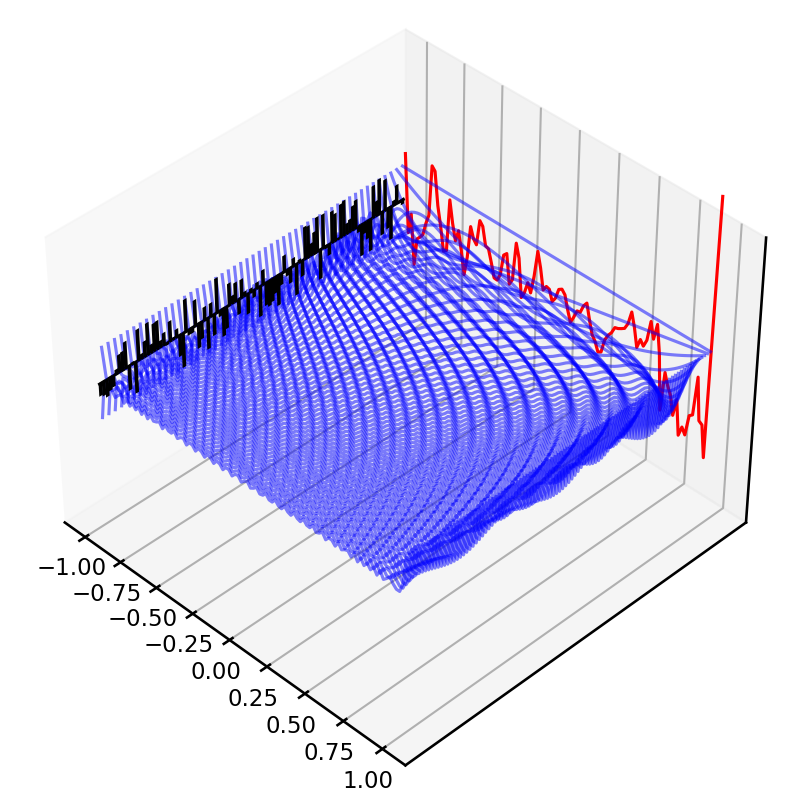

In [ ]:
example_legendre()

Красная линия представляет ту кривую, которую мы аппроксимируем, а черные полосы представляют значения нашего скрытого состояния. Каждый из них представляет собой коэффициент для одного элемента ряда Лежандра, показанного синими функциями. Интуитивно понятно, что матрица HiPPO обновляет эти коэффициенты на каждом этапе.

# Часть 2. Реализация S4
---
Внимание: в этом разделе много математики. Грубо говоря, все сводится к поиску способа очень быстрого вычисления фильтра из первой части для «HiPPO-подобных» матриц. Если вам интересно, детали действительно аккуратные. Если нет, перейдите к части 3, чтобы узнать о некоторых интересных приложениях, таких как завершение MNIST.

Чтобы подготовить почву, напомним, что S4 имеет два основных отличия от базового SSM. Первый решает задачу моделирования долгосрочных зависимостей используя специальную формулу для матрицы $\overline{A}$, определенной в предыдущей части. Эти специальные SSM рассматривались в работах, предшествующих S4.

Вторая основная особенность - S4 решает вычислительную задачу SSM, вводя специальное представление и алгоритм для работы с этой матрицей!

>Фундаментальным узким местом в вычислении SSM дискретного времени является то, что он включает в себя многократное умножение матриц на $\overline{A}$. Например, вычисления наивно включают в себя
$L$ последовательных умножение на $\overline{A}$, требующее $O(N^2L)$ операций в $O(NL)$ пространстве.

В частности, вспомните эту функцию:

In [ ]:
def K_conv(Ab, Bb, Cb, L):
   return np.array(
       [(Cb @ matrix_power(Ab, l) @ Bb).reshape() for l in range(L)]
   )

Вклад S4 — это стабильный метод ускорения этой конкретной операции. Для этого мы сосредоточимся на случае, когда SSM имеет специальную структуру: в частности, Diagonal Plus Low-Rank $DPLR$ в комплексном пространстве.

SSM $DPLR$ - это $(Λ−PQ^∗,B,C)$ для некоторой диагонали $Λ$ и матриц $P,Q,B,C∈\mathbb{C}^{N×1}$. Без ограничения общности будем считать, что ранг равен 1, т.е. эти матрицы являются векторами.

Согласно этому предположению $DPLR$, S4 преодолевает узкое место в скорости в три этапа.

>1. Вместо вычислений непосредственно $\overline{A}$, мы вычисляем его спектр, оценивая его [усеченную производящую функцию](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%BE%D0%B8%D0%B7%D0%B2%D0%BE%D0%B4%D1%8F%D1%89%D0%B0%D1%8F_%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%BF%D0%BE%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D0%B8). Теперь здесь используется обратная матрица вместо степени.<br><br>
2. Мы показываем, что случай диагональной матрицы эквивалентен вычислению ядра [Коши](https://ru.wikipedia.org/wiki/%D0%9C%D0%B0%D1%82%D1%80%D0%B8%D1%86%D0%B0_%D0%9A%D0%BE%D1%88%D0%B8_(%D0%BB%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%B0%D1%8F_%D0%B0%D0%BB%D0%B3%D0%B5%D0%B1%D1%80%D0%B0)). $\frac{1}{ω_{j}-ζ_k}$.<br><br>
3. Мы показываем, что член низкого ранга теперь можно исправить, применив [тождество Вудбери](https://en.wikipedia.org/wiki/Woodbury_matrix_identity) , которое уменьшает $(Λ+PQ^∗)^{−1}$. что при $Λ^{−1}$ действительно сводится к диагональному случаю.

# Шаг 1. Генерирующие функции SSM
Основным шагом будет переход от вычисления последовательности к вычислению её производящей функции. Из приложения к статье:

>Для решения проблемы вычислительных мощностей $\overline{A}$, мы представляем еще одну технику. Вместо вычисления сверточного фильтра SSM $\overline{K}$ непосредственно мы вводим производящую функцию, по ее коэффициентам и вычисляем ее оценки.<br><br>
Усеченная генерирующая функция SSM в узле $z$ с усечением $L$ является
$$\hat{К}_L(z;\overline{A}, \overline{B}, \overline{C})∈\mathbb{C}:=\sum_{i=0}^{L-1} \overline{C}\overline{A}^i\overline{B}z^i$$


In [ ]:
def K_gen_simple(Ab, Bb, Cb, L):
    K = K_conv(Ab, Bb, Cb, L)

    def gen(z):
        return np.sum(K * (z ** np.arange(L)))

    return gen

>Генераторная функция по существу преобразует сверточный фильтр SSM из временной области в частотную область. Это преобразование также называется [z-преобразованием](https://ru.wikipedia.org/wiki/Z-%D0%BF%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5) (до знака минус) в литературе по технике управления. Важно отметить, что он сохраняет ту же информацию, и нужный сверточный фильтр SSM можно восстановить. Как только z-преобразование дискретной последовательности известно, мы можем получить дискретное преобразование Фурье фильтра из оценок его z-преобразования в корнях из единицы.
$\Omega=\{exp(2\pi\frac{k}{L}:k∈[L]\}$. Затем мы можем применить обратное преобразование Фурье, стабильно за $O(LlogL)$ операций, применяя БПФ для восстановления фильтра.

In [ ]:
def conv_from_gen(gen, L):
    # Evaluate at roots of unity
    # Generating function is (-)z-transform, so we evaluate at (-)root
    Omega_L = np.exp((-2j * np.pi) * (np.arange(L) / L))
    atRoots = jax.vmap(gen)(Omega_L)
    # Inverse FFT
    out = np.fft.ifft(atRoots, L).reshape(L)
    return out.real

Что еще более важно, в производящей функции мы можем заменить степень матрицы обратной!
$$\hat{К}(z)=\sum_{i=0}^{L-1}\overline{C}\overline{A}^i\overline{B}z^i=\overline{C}(I-\overline{A}^Lz^L)(I-\overline{A}z)^{-1}\overline{B}=\widetilde{C}(I-\overline{A}z)^{-1}\overline{B}$$

И для всех $z∈\Omega_L$, у нас есть $z^L=1$ так что это выражение можно удалить. Затем мы переносим этот постоянный член в новый $\widetilde{C}$. Крайне важно, что эта функция не вызывает K_conv,

In [ ]:
def K_gen_inverse(Ab, Bb, Cb, L):
    I = np.eye(Ab.shape[0])
    Ab_L = matrix_power(Ab, L)
    Ct = Cb @ (I - Ab_L)
    return lambda z: (Ct.conj() @ inv(I - Ab * z) @ Bb).reshape()

Но он выводит те же значения,

In [ ]:
def test_gen_inverse(L=16, N=4):
    ssm = random_SSM(rng, N)
    ssm = discretize(*ssm, 1.0 / L)
    b = K_conv(*ssm, L=L)

    a = conv_from_gen(K_gen_inverse(*ssm, L=L), L)
    assert np.allclose(a, b)

Таким образом, шаг 1 позволяет нам заменить степень матрицы обратной, используя усеченную производящую функцию. Однако все это еще необходимо вычислить $L$ раз (для каждого из корней из единицы).

# Шаг 2: Диагональный случай
Следующий шаг — применить специальную структуру матрицы $A$ для более быстрых вичислений, чем простая инверсия. Для начала давайте преобразуем приведенное выше уравнение, чтобы использовать исходные матрицы SSM. С помощью некоторой алгебры вы можете расширить дискретизацию и показать:<br><br>
$$
\widetilde{C}(I-\overline{A})^{-1}\overline{B}-\frac{2Δ}{1+z}\widetilde{C}\begin{bmatrix}2\frac{1-z}{1+z}-ΔA\end{bmatrix}^{-1}B\\
$$

Теперь представьте себе $А=Λ$ по диагонали $Λ$. Подставив в формулу дискретизации, авторы показывают, что производящую функцию можно записать следующим образом:<br><br>
$$
\hat{K}_Λ(z)=c(z)\sum_i̇\frac{\widetilde{C}_iB_i}{(g(z)-Λ_i)}=c(z)k_{z,Λ}(\widetilde{C},B)\\
$$
где $c$ является константой, и $g$ является функцией от $z$.

Мы фактически заменили обратное на взвешенное скалярное произведение. Давайте создадим небольшую вспомогательную функцию для вычисления скалярного произведения весов для дальнейшего использования.

In [ ]:
def cauchy_dot(v, omega, lambd):
    return (v / (omega - lambd)).sum()

Хотя это и не важно для нашей реализации, стоит отметить, что это ядро ​​Коши и оно является предметом многих [других быстрых реализаций](https://ru.wikipedia.org/wiki/%D0%91%D1%8B%D1%81%D1%82%D1%80%D1%8B%D0%B9_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4_%D0%BC%D1%83%D0%BB%D1%8C%D1%82%D0%B8%D0%BF%D0%BE%D0%BB%D0%B5%D0%B9).

#Шаг 3: Диагональ плюс низкий ранг
Последний шаг — ослабить диагональное предположение. Помимо диагонального члена мы допускаем компонент низкого ранга с $P,Q∈\mathbb{C}^{N×1}$ такой, что:
$$
A=Λ-PQ^*
$$

Тождество Вудбери говорит нам, что обратная диагональ плюс член ранга 1 равна обратной диагонали плюс член ранга 1. Запишем это здесь, добавив термин низкого ранга.
$$
(Λ+PQ^*)^{-1}=Λ^{-1}-Λ^{-1}P(1+Q^*Λ^{-1}P)^{-1}Q^*Λ^{-1}
$$

В приложении есть куча алгебры. В основном он состоит из замены этого компонента на $A$, с применением тождества Вудбери и условий распределения. В итоге мы получили 4 термина, которые выглядят как шаг 2 выше:
$$
\hat{K}_{DPLR}(z)=c(z)[k_{z,Λ}(\widetilde{C},B)-k_{z,Λ}(\widetilde{C},P)(1+k_{z,Λ}(q^*,P))^{-1}k_{z,Λ}(q^*,B)]
$$
Код состоит из сбора терминов и применения 4-х взвешенных скалярных произведений:

In [ ]:
def K_gen_DPLR(Lambda, P, Q, B, C, step, unmat=False):
    aterm = (C.conj(), Q.conj())
    bterm = (B, P)

    def gen(o):
        g = (2.0 / step) * ((1.0 - o) / (1.0 + o))
        c = 2.0 / (1.0 + o)

        def k(a):
            # Checkpoint this calculation for memory efficiency.
            if unmat:
                return jax.remat(cauchy_dot)(a, g, Lambda)
            else:
                return cauchy_dot(a, g, Lambda)

        k00 = k(aterm[0] * bterm[0])
        k01 = k(aterm[0] * bterm[1])
        k10 = k(aterm[1] * bterm[0])
        k11 = k(aterm[1] * bterm[1])
        return c * (k00 - k01 * (1.0 / (1.0 + k11)) * k10)

    return gen

Это наша финальная версия $K$ функции. Поскольку $\text{conv_from_gen}$ всегда вызывается вместе с производящей функцией (например,  $\text{K_gen_DPLR}$), мы объединим их, чтобы определить специальную функцию для вычисления ядра $DPLR$ SSM на основе всех его параметров. (Благодаря меньшему количеству уровней косвенности это также может облегчить оптимизацию компилятора XLA.)

In [ ]:
@jax.jit
def cauchy(v, omega, lambd):
    """Cauchy matrix multiplication: (n), (l), (n) -> (l)"""
    cauchy_dot = lambda _omega: (v / (_omega - lambd)).sum()
    return jax.vmap(cauchy_dot)(omega)

In [ ]:
def kernel_DPLR(Lambda, P, Q, B, C, step, L):
    # Evaluate at roots of unity
    # Generating function is (-)z-transform, so we evaluate at (-)root
    Omega_L = np.exp((-2j * np.pi) * (np.arange(L) / L))

    aterm = (C.conj(), Q.conj())
    bterm = (B, P)

    g = (2.0 / step) * ((1.0 - Omega_L) / (1.0 + Omega_L))
    c = 2.0 / (1.0 + Omega_L)

    # Reduction to core Cauchy kernel
    k00 = cauchy(aterm[0] * bterm[0], g, Lambda)
    k01 = cauchy(aterm[0] * bterm[1], g, Lambda)
    k10 = cauchy(aterm[1] * bterm[0], g, Lambda)
    k11 = cauchy(aterm[1] * bterm[1], g, Lambda)
    atRoots = c * (k00 - k01 * (1.0 / (1.0 + k11)) * k10)
    out = np.fft.ifft(atRoots, L).reshape(L)
    return out.real

Теперь мы можем проверить, сработало ли это. Во-первых, давайте сгенерируем случайную матрицу Диагональ Плюс Низкий Ранг ($DPLR$),

In [ ]:
def random_DPLR(rng, N):
    l_r, p_r, q_r, b_r, c_r = jax.random.split(rng, 5)
    Lambda = jax.random.uniform(l_r, (N,))
    P = jax.random.uniform(p_r, (N,))
    Q = jax.random.uniform(q_r, (N,))
    B = jax.random.uniform(b_r, (N, 1))
    C = jax.random.uniform(c_r, (1, N))
    return Lambda, P, Q, B, C

Мы можем проверить, что метод $DPLR$ дает тот же фильтр, что и вычисление
$A$ напрямую,

In [ ]:
def test_gen_dplr(L=16, N=4):
    I = np.eye(4)

    # Create a DPLR A matrix and discretize
    Lambda, P, B, _ = make_DPLR_HiPPO(N)
    A = np.diag(Lambda) - P[:, np.newaxis] @ P[:, np.newaxis].conj().T
    _, _, C = random_SSM(rng, N)

    Ab, Bb, Cb = discretize(A, B, C, 1.0 / L)
    a = K_conv(Ab, Bb, Cb.conj(), L=L)

    # Compare to the DPLR generating function approach.
    C = (I - matrix_power(Ab, L)).conj().T @ Cb.ravel()
    b = kernel_DPLR(Lambda, P, P, B, C, step=1.0 / L, L=L)
    assert np.allclose(a.real, b.real)

# Диагональ плюс RNN низкого ранга.
Вторичным преимуществом факторизации $DPLR$ является то, что она позволяет нам вычислить дискретизированную форму SSM без необходимости инвертировать матрицу $A$ напрямую. Здесь мы возвращаемся к статье о выводе.
<br>
>Напомним, что дискретизация вычисляет:
$$
\overline{A}=(I-Δ/2 ⋅ A)^{-1}(I+Δ/2 ⋅ A)\\
\overline{B}=(I-Δ/2 ⋅ A)^{-1}ΔB\\
$$
Упростим оба термина в определении $\overline{A}$ независимо.
Первое выражение:
$$
I+\frac{Δ}{2}A=I+\frac{Δ}{2}(Λ-PQ^*)=\frac{Δ}{2}\begin{bmatrix}\frac{2}{Δ}I+(Λ-PQ^*)\end{bmatrix}=\frac{Δ}{2}A_0
$$
где $A_0$ определяется как выражение в последних скобках.
<br><br>
Второе выражение известено как [обратный метод Эйлера](https://en.wikipedia.org/wiki/Backward_Euler_method). Хотя с этим обратным выражение обычно трудно иметь дело, в случае $DPLR$ мы можем упростить его, используя идентичность Вудбери, как описано выше.
$$
(I-\frac{Δ}{2})^{-1}=(I-\frac{Δ}{2}(Λ-PQ^*))^{-1}=\frac{2}{Δ}\begin{bmatrix}\frac{2}{Δ}-Λ+PQ^*\end{bmatrix}^{-1}=\frac{2}{Δ}\begin{bmatrix}D-DP(1-Q^*DP)^{-1}Q^*D\end{bmatrix}=\frac{2}{Δ}A_1\\
$$
где $A=(\frac{2}{Δ} - Λ)^{-1}$ и $A_1$ определяется как выражение в последних скобках.
<br><br>
SSM дискретного времени становится
$$
x_k=\overline{A}x_{k-1}+\overline{B}u_k=A_1A_0x_{k-1}+2A_1Bu_k\\
y_k=Cx_k
$$


In [ ]:
def discrete_DPLR(Lambda, P, Q, B, C, step, L):
    # Convert parameters to matrices
    B = B[:, np.newaxis]
    Ct = C[np.newaxis, :]

    N = Lambda.shape[0]
    A = np.diag(Lambda) - P[:, np.newaxis] @ Q[:, np.newaxis].conj().T
    I = np.eye(N)

    # Forward Euler
    A0 = (2.0 / step) * I + A

    # Backward Euler
    D = np.diag(1.0 / ((2.0 / step) - Lambda))
    Qc = Q.conj().T.reshape(1, -1)
    P2 = P.reshape(-1, 1)
    A1 = D - (D @ P2 * (1.0 / (1 + (Qc @ D @ P2))) * Qc @ D)

    # A bar and B bar
    Ab = A1 @ A0
    Bb = 2 * A1 @ B

    # Recover Cbar from Ct
    Cb = Ct @ inv(I - matrix_power(Ab, L)).conj()
    return Ab, Bb, Cb.conj()

# Превращение HiPPO в DPLR
Этот подход применим к матрицам DPLR, но помните, что мы хотели бы, чтобы он также применялся к матрице HiPPO. Матрица HiPPO не является DPLR в ее нынешнем виде, но имеет особую структуру. Это Normal Plus Low-Rank (NPLR). Поскольку нормальные матрицы представляют собой именно тот класс матриц, которые являются диагонализуемыми унитарно, матрицы NPLR по существу эквивалентны матрицам DPLR с точки зрения моделей SSM. это так же хорошо, как и DPLR, для обучения сети SSM.

>Методы S4 могут применяться к любой матрице $A$ которую можно разложить на Normal Plus Low-Rank (NPLR).<br><br>
$$
A=VΛV^*-PQ^T=V(Λ-V^*P(V^*Q)^*)V^*\\
$$
для унитарного $V∈\mathbb{C}^{N×N}$, диагональ $Λ$ и факторизация низкого ранга $P,Q∈\mathbb{R}^{N×r}$. Таким образом, SSM NPLR унитарно эквивалентен некоторой матрице DPLR.

Для S4 нам нужно работать с матрицей HiPPO для $A$. Для этого необходимо сначала записать его как обычный термин плюс член низкого ранга, а затем провести диагонализацию для извлечения $Λ$ от этого разложения. В приложении к статье показано, как записать нормальную часть в виде кососимметричной (плюс константы, умноженной на единичную матрицу), которые представляют собой особый класс нормальных матриц.

Дополнительное упрощение состоит в том, что на самом деле существует представление, связывающее члены компонентов низкого ранга $P=Q$, что, как было показано в последующих работах, важно для стабильности.

In [ ]:
def make_NPLR_HiPPO(N):
    # Make -HiPPO
    nhippo = make_HiPPO(N)

    # Add in a rank 1 term. Makes it Normal.
    P = np.sqrt(np.arange(N) + 0.5)

    # HiPPO also specifies the B matrix
    B = np.sqrt(2 * np.arange(N) + 1.0)
    return nhippo, P, B

После извлечения нормальной части мы можем провести диагонализацию, чтобы получить выражения DPLR. Поскольку нормальная часть на самом деле кососимметрична, мы можем извлечь действительные и сложные части $Λ$ в отдельности. Это служит двум целям. Во-первых, это дает нам более детальный контроль над действительными и мнимыми частями, что можно использовать для повышения стабильности. Во-вторых, это позволяет нам использовать более мощные алгоритмы диагонализации для [эрмитовых матриц](https://ru.wikipedia.org/wiki/%D0%AD%D1%80%D0%BC%D0%B8%D1%82%D0%BE%D0%B2%D0%B0_%D0%BC%D0%B0%D1%82%D1%80%D0%B8%D1%86%D0%B0) — фактически текущая версия JAX не поддерживает диагонализацию GPU для неэрмитовых матриц!

In [ ]:
def make_DPLR_HiPPO(N):
    """Diagonalize NPLR representation"""
    A, P, B = make_NPLR_HiPPO(N)

    S = A + P[:, np.newaxis] * P[np.newaxis, :]

    # Check skew symmetry
    S_diag = np.diagonal(S)
    Lambda_real = np.mean(S_diag) * np.ones_like(S_diag)
    # assert np.allclose(Lambda_real, S_diag, atol=1e-3)

    # Diagonalize S to V \Lambda V^*
    Lambda_imag, V = eigh(S * -1j)

    P = V.conj().T @ P
    B = V.conj().T @ B
    return Lambda_real + 1j * Lambda_imag, P, B, V

Проверка здравомыслия, чтобы убедиться, что эти личности верны,

In [ ]:
def test_nplr(N=8):
    A2, P, B = make_NPLR_HiPPO(N)
    Lambda, Pc, Bc, V = make_DPLR_HiPPO(N)
    Vc = V.conj().T
    P = P[:, np.newaxis]
    Pc = Pc[:, np.newaxis]
    Lambda = np.diag(Lambda)

    A3 = V @ Lambda @ Vc - (P @ P.T)  # Test NPLR
    A4 = V @ (Lambda - Pc @ Pc.conj().T) @ Vc  # Test DPLR
    assert np.allclose(A2, A3, atol=1e-4, rtol=1e-4)
    assert np.allclose(A2, A4, atol=1e-4, rtol=1e-4)

# Окончательная проверка
Проверим, что все работает так, как запланировано.

In [ ]:
def test_conversion(N=8, L=16):
    step = 1.0 / L
    # Compute a HiPPO NPLR matrix.
    Lambda, P, B, _ = make_DPLR_HiPPO(N)
    # Random complex Ct
    C = normal(dtype=np.complex64)(rng, (N,))

    # CNN form.
    K = kernel_DPLR(Lambda, P, P, B, C, step, L)

    # RNN form.
    Ab, Bb, Cb = discrete_DPLR(Lambda, P, P, B, C, step, L)
    K2 = K_conv(Ab, Bb, Cb, L=L)
    assert np.allclose(K.real, K2.real, atol=1e-5, rtol=1e-5)

    # Apply CNN
    u = np.arange(L) * 1.0
    y1 = causal_convolution(u, K.real)

    # Apply RNN
    _, y2 = scan_SSM(
        Ab, Bb, Cb, u[:, np.newaxis], np.zeros((N,)).astype(np.complex64)
    )
    assert np.allclose(y1, y2.reshape(-1).real, atol=1e-4, rtol=1e-4)

# Часть 3: S4 на практике
Мы проделали большую работу, но теперь реальная модель стала лаконичной. На самом деле мы используем только четыре функции:

1. K_gen_DPLR → Усеченная производящая функция, когда $A$ это DPLR (часть S4)
2. conv_from_gen → Преобразовать производящую функцию в фильтр
3. causal_convolution → Запустить свертку
4. discretize_DPLR → Преобразовать SSM в дискретную форму для RNN.

# S4 Уровень CNN/RNN
Полный уровень S4 очень похож на простой уровень SSM, описанный выше. Единственная разница заключается в расчете $K$. Дополнительно вместо обучения $C$, мы учим $\widetilde{C}$ поэтому мы избегаем вычислительных затрат на $A$. Также отметим, что в оригинальной статье $Λ,P,Q$ также обучаются. Однако в этом посте мы оставляем их фиксированными для простоты.

In [ ]:
class S4Layer(nn.Module):
    N: int
    l_max: int
    decode: bool = False

    # Special parameters with multiplicative factor on lr and no weight decay (handled by main train script)
    lr = {
        "Lambda_re": 0.1,
        "Lambda_im": 0.1,
        "P": 0.1,
        "B": 0.1,
        "log_step": 0.1,
    }

    def setup(self):
        # Learned Parameters (C is complex!)
        init_A_re, init_A_im, init_P, init_B = hippo_initializer(self.N)
        self.Lambda_re = self.param("Lambda_re", init_A_re, (self.N,))
        self.Lambda_im = self.param("Lambda_im", init_A_im, (self.N,))
        # Ensure the real part of Lambda is negative
        # (described in the SaShiMi follow-up to S4)
        self.Lambda = np.clip(self.Lambda_re, None, -1e-4) + 1j * self.Lambda_im
        self.P = self.param("P", init_P, (self.N,))
        self.B = self.param("B", init_B, (self.N,))
        # C should be init as standard normal
        # This doesn't work due to how JAX handles complex optimizers https://github.com/deepmind/optax/issues/196
        # self.C = self.param("C", normal(stddev=1.0, dtype=np.complex64), (self.N,))
        self.C = self.param("C", normal(stddev=0.5**0.5), (self.N, 2))
        self.C = self.C[..., 0] + 1j * self.C[..., 1]
        self.D = self.param("D", nn.initializers.ones, (1,))
        self.step = np.exp(self.param("log_step", log_step_initializer(), (1,)))

        if not self.decode:
            # CNN mode, compute kernel.
            self.K = kernel_DPLR(
                self.Lambda,
                self.P,
                self.P,
                self.B,
                self.C,
                self.step,
                self.l_max,
            )

        else:
            # RNN mode, discretize

            # Flax trick to cache discrete form during decoding.
            def init_discrete():
                return discrete_DPLR(
                    self.Lambda,
                    self.P,
                    self.P,
                    self.B,
                    self.C,
                    self.step,
                    self.l_max,
                )

            ssm_var = self.variable("prime", "ssm", init_discrete)
            if self.is_mutable_collection("prime"):
                ssm_var.value = init_discrete()
            self.ssm = ssm_var.value

            # RNN Cache
            self.x_k_1 = self.variable(
                "cache", "cache_x_k", np.zeros, (self.N,), np.complex64
            )

    def __call__(self, u):
        # This is identical to SSM Layer
        if not self.decode:
            # CNN Mode
            return causal_convolution(u, self.K) + self.D * u
        else:
            # RNN Mode
            x_k, y_s = scan_SSM(*self.ssm, u[:, np.newaxis], self.x_k_1.value)
            if self.is_mutable_collection("cache"):
                self.x_k_1.value = x_k
            return y_s.reshape(-1).real + self.D * u

In [ ]:
S4Layer = cloneLayer(S4Layer)

Мы инициализируем модель, вычисляя инициализатор HiPPO DPLR.

In [ ]:
# Factory for constant initializer in Flax
def init(x):
    def _init(key, shape):
        assert shape == x.shape
        return x

    return _init

In [ ]:
def hippo_initializer(N):
    Lambda, P, B, _ = make_DPLR_HiPPO(N)
    return init(Lambda.real), init(Lambda.imag), init(P), init(B)

# Выборка и кэширование
Мы можем выполнить выборку из модели, используя реализацию RNN. Вот как выглядит код выборки. Обратите внимание, что мы сохраняем работающий кеш для запоминания состояния RNN.

In [ ]:
def sample(model, params, prime, cache, x, start, end, rng):
    def loop(i, cur):
        x, rng, cache = cur
        r, rng = jax.random.split(rng)
        out, vars = model.apply(
            {"params": params, "prime": prime, "cache": cache},
            x[:, np.arange(1, 2) * i],
            mutable=["cache"],
        )

        def update(x, out):
            p = jax.random.categorical(r, out[0])
            x = x.at[i + 1, 0].set(p)
            return x

        x = jax.vmap(update)(x, out)
        return x, rng, vars["cache"].unfreeze()

    return jax.lax.fori_loop(start, end, jax.jit(loop), (x, rng, cache))[0]

Чтобы получить это в хорошей форме, мы сначала предварительно вычисляем дискретизированную версию RNN для каждого слоя S4. Мы делаем это с помощью «простого» набора переменных.

In [ ]:
def init_recurrence(model, params, init_x, rng):
    variables = model.init(rng, init_x)
    vars = {
        "params": params,
        "cache": variables["cache"].unfreeze(),
        "prime": variables["prime"].unfreeze(),
    }
    print("[*] Priming")
    _, prime_vars = model.apply(vars, init_x, mutable=["prime"])
    return vars["params"], prime_vars["prime"], vars["cache"]

Подводя итог вышесказанному, мы можем напрямую брать образцы из модели.

In [ ]:
def sample_checkpoint(path, model, length, rng):
    from flax.training import checkpoints

    start = np.zeros((1, length, 1), dtype=int)

    print("[*] Initializing from checkpoint %s" % path)
    state = checkpoints.restore_checkpoint(path, None)
    assert "params" in state
    params, prime, cache = init_recurrence(model, state["params"], start, rng)
    print("[*] Sampling output")
    return sample(model, params, prime, cache, start, 0, length - 1, rng)

# Эксперименты: MNIST
Теперь, когда у нас есть модель, мы можем опробовать ее в экспериментах MNIST. Для этих экспериментов мы линеаризуем MNIST и просто рассматриваем каждое изображение как последовательность пикселей.

Первые эксперименты, которые мы провели, касались классификации MNIST. Хотя теоретически это не сложная проблема, рассматривать MNIST как задачу классификации линейных последовательностей немного странно. Однако на практике модель с $H=256$ и четыре слоя, похоже, сразу достигают 99%.

Более визуально интересная задача — генерация цифр MNIST путем прогнозирования целых последовательностей пикселей! Здесь мы просто вводим в модель последовательность пикселей, и она прогнозирует следующий, как при языковом моделировании. После небольшой настройки мы можем получить NLL модели 0,36 для этой задачи с размером 512 и 6 слоями (~ 4 млн параметров).

Метрикой, обычно используемой для этой задачи, является [число битов на измерение](https://paperswithcode.com/sota/image-generation-on-mnist), которое для MNIST представляет собой NLL по основанию 2. Потеря 0,36 составляет ~0,52 BPD, что соответствует SOTA согласно PapersWithCode.

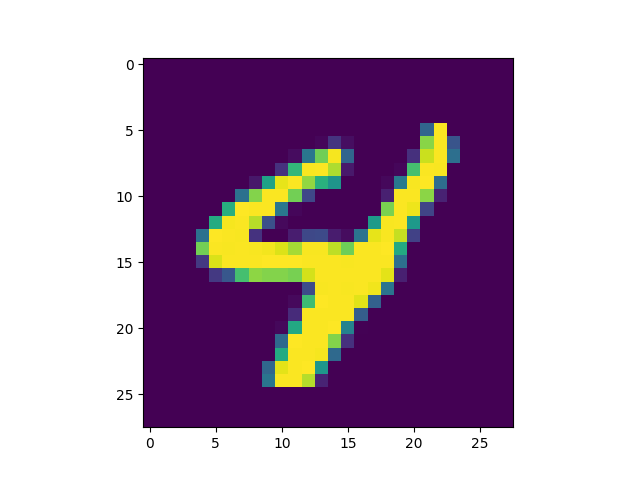

Также мы можем делать префиксы-сэмплы — учитывая первые 300 пикселей, пытаемся завершить изображение. S4 находится слева, правда справа.

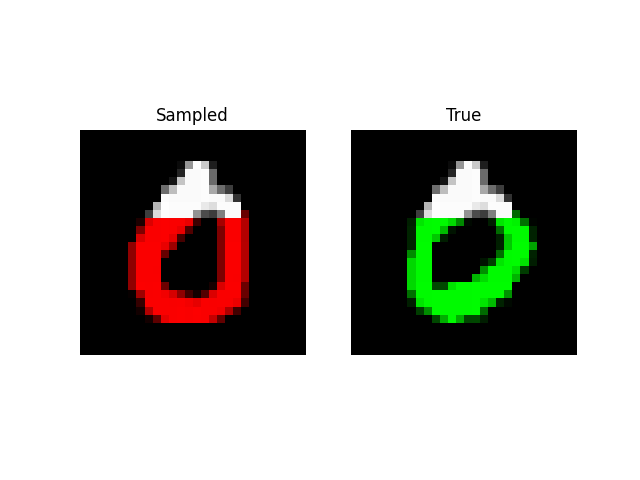


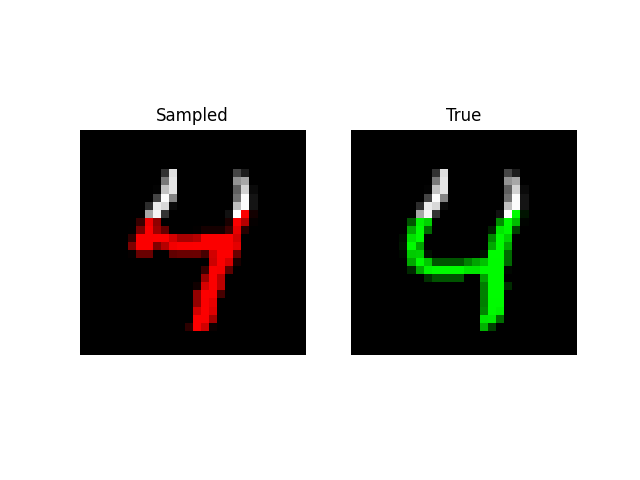


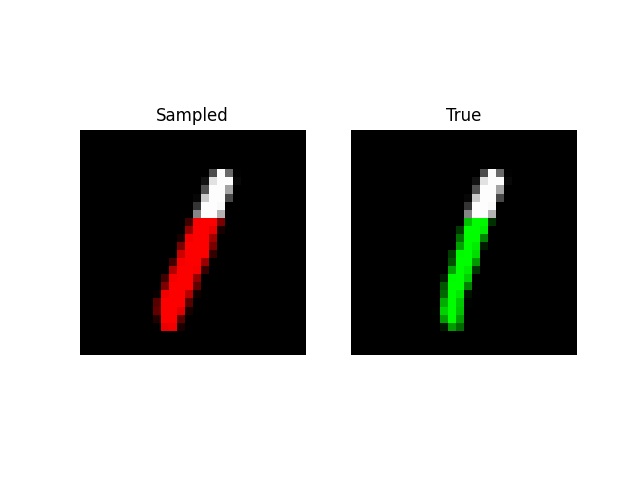


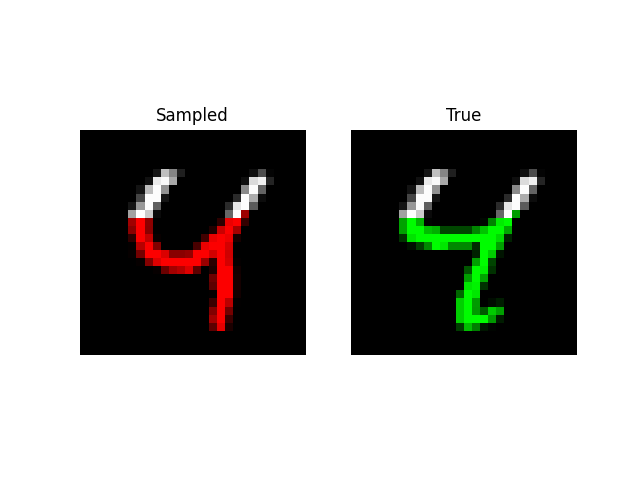


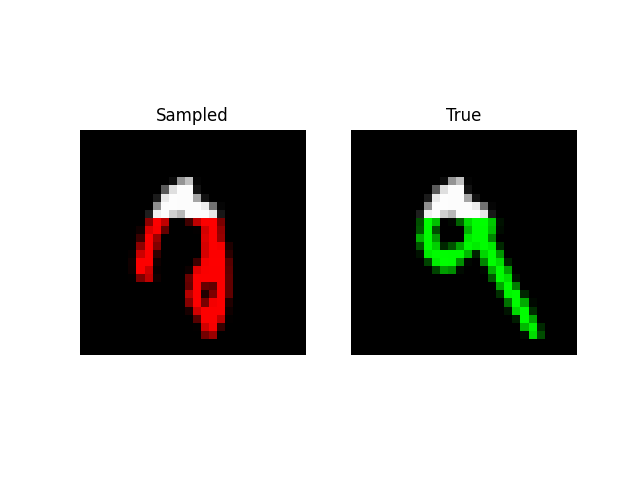


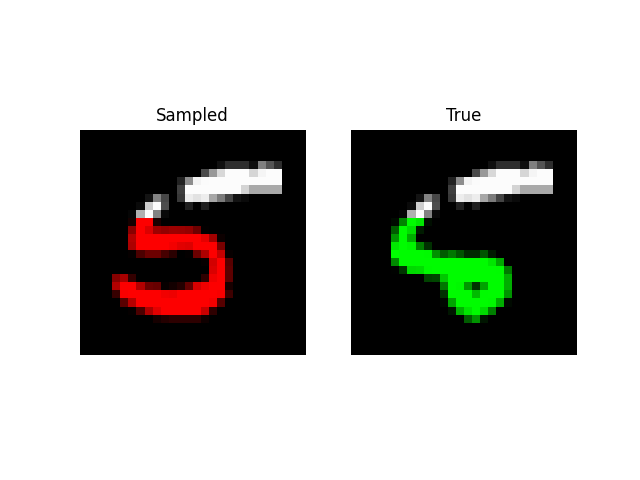

In [ ]:
def sample_image_prefix(
    params,
    model,
    # length,
    rng,
    dataloader,
    prefix=300,
    # bsz=32,
    imshape=(28, 28),
    n_batches=None,
    save=True,
):
    """Sample a grayscale image represented as intensities in [0, 255]"""
    import matplotlib.pyplot as plt
    import numpy as onp

    # from .data import Datasets
    # BATCH = bsz
    # start = np.zeros((BATCH, length), dtype=int)
    # start = np.zeros((BATCH, length, 1), dtype=int)
    start = np.array(next(iter(dataloader))[0].numpy())
    start = np.zeros_like(start)
    # params, prime, cache = init_recurrence(model, params, start[:, :-1], rng)
    params, prime, cache = init_recurrence(model, params, start, rng)

    BATCH = start.shape[0]
    START = prefix
    LENGTH = start.shape[1]
    assert LENGTH == onp.prod(imshape)

    # _, dataloader, _, _, _ = Datasets["mnist"](bsz=BATCH)
    it = iter(dataloader)
    for j, im in enumerate(it):
        if n_batches is not None and j >= n_batches:
            break

        image = im[0].numpy()
        image = np.pad(
            image[:, :-1, :], [(0, 0), (1, 0), (0, 0)], constant_values=0
        )
        cur = onp.array(image)
        # cur[:, START + 1 :, 0] = 0
        # cur = np.pad(cur[:, :-1, 0], [(0, 0), (1, 0)], constant_values=256)
        cur = np.array(cur[:, :])

        # Cache the first `start` inputs.
        out, vars = model.apply(
            {"params": params, "prime": prime, "cache": cache},
            cur[:, np.arange(0, START)],
            mutable=["cache"],
        )
        cache = vars["cache"].unfreeze()
        out = sample(model, params, prime, cache, cur, START, LENGTH - 1, rng)

        # Visualization
        out = out.reshape(BATCH, *imshape)
        final = onp.zeros((BATCH, *imshape, 3))
        final2 = onp.zeros((BATCH, *imshape, 3))
        final[:, :, :, 0] = out
        f = final.reshape(BATCH, LENGTH, 3)
        i = image.reshape(BATCH, LENGTH)
        f[:, :START, 1] = i[:, :START]
        f[:, :START, 2] = i[:, :START]
        f = final2.reshape(BATCH, LENGTH, 3)
        f[:, :, 1] = i
        f[:, :START, 0] = i[:, :START]
        f[:, :START, 2] = i[:, :START]
        if save:
            for k in range(BATCH):
                fig, (ax1, ax2) = plt.subplots(ncols=2)
                ax1.set_title("Sampled")
                ax1.imshow(final[k] / 256.0)
                ax2.set_title("True")
                ax1.axis("off")
                ax2.axis("off")
                ax2.imshow(final2[k] / 256.0)
                fig.savefig("im%d.%d.png" % (j, k))
                plt.close()
                print(f"Sampled batch {j} image {k}")
    return final, final2

# Эксперименты: QuickDraw
Затем мы попытались обучить модель созданию чертежей. Для этого мы использовали набор данных QuickDraw. Набор данных включает в себя версию набора данных, уменьшенную до размера MNIST, поэтому мы можем использовать примерно ту же модель, что и выше. Однако набор данных намного больше (5 миллионов изображений) и сложнее. Мы тренировались только одну эпоху с $H=256$, 4-х слойная модель. Тем не менее, этот подход позволил обеспечить относительно последовательные завершения. Это образцы префиксов с указанием 500 пикселей.

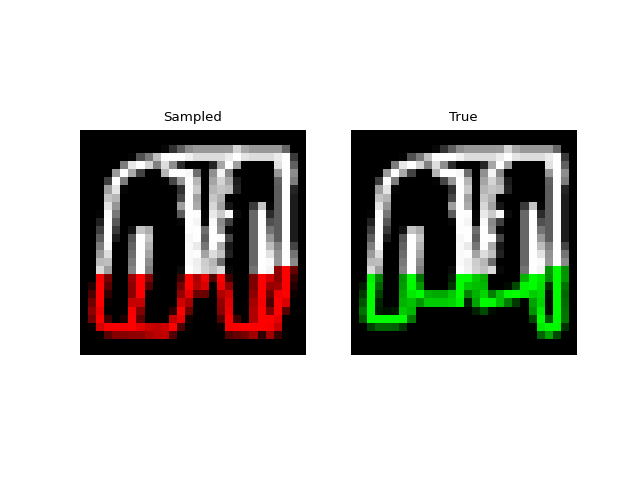


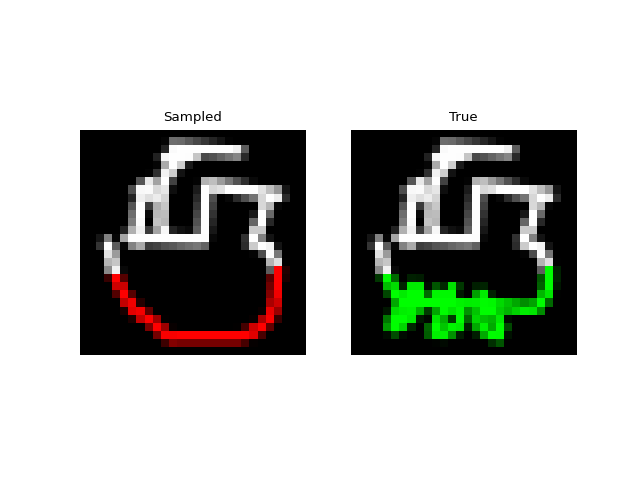


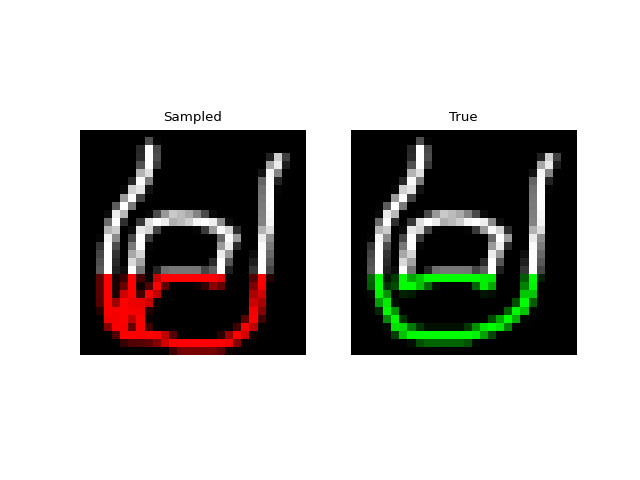


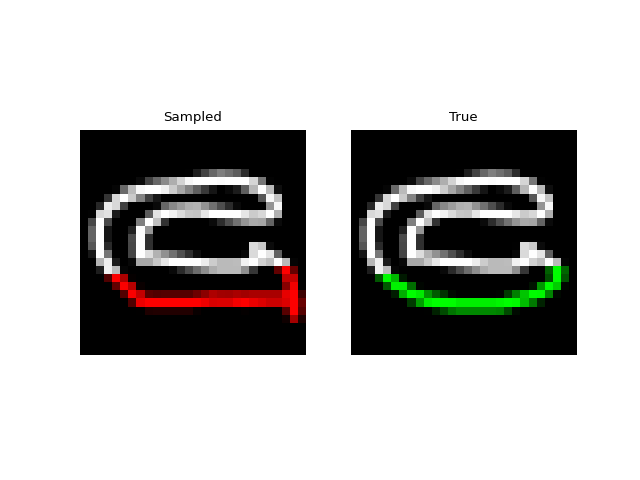


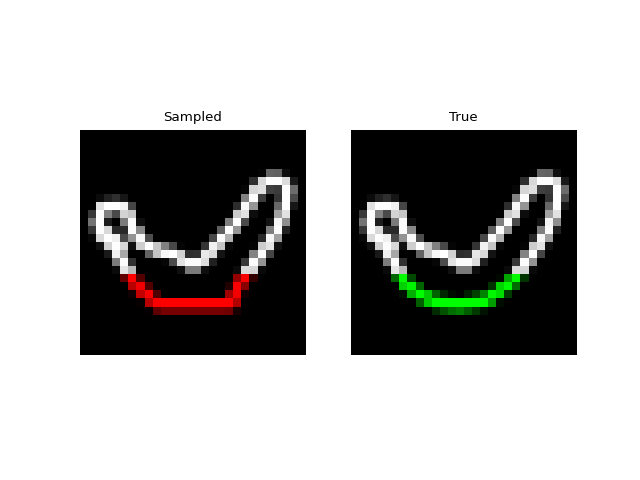


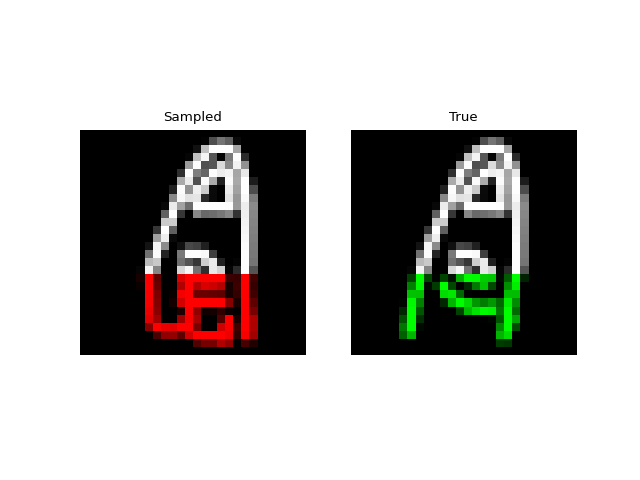

# Эксперименты: произнесение цифр
Наконец, мы поигрались непосредственно с моделированием звуковых волн. Для этого мы используем наборы данных [Free Spoken Digits](https://github.com/Jakobovski/free-spoken-digit-dataset), подобные MNIST, набор данных различных говорящих, считывающих цифры. Сначала мы обучили модель классификации и обнаружили, что этот подход способен достичь $97%$ точность только на основе необработанной звуковой волны. Затем мы обучили модель генерации непосредственно генерировать звуковую волну. С $H=516$ модель, похоже, относительно хорошо собирает данные. Этот набор данных содержит всего около 3000 примеров, но модель может давать достаточно хорошие (отобранные) продолжения. Обратите внимание, что эти последовательности имеют длину 6400 шагов при частоте дискретизации 8 кГц и дискретизированы до 256 классов с помощью кодирования по [закону Mu](https://ru.wikipedia.org/wiki/%D0%9C%D1%8E-%D0%B7%D0%B0%D0%BA%D0%BE%D0%BD).

Наша [полная база кода](https://github.com/srush/annotated-s4/) содержит больше примеров и инфраструктуру для обучения моделей поколений и классификации.

# Заключение
Составление этого поста вдохновило на множество мыслей о будущей работе в этой области. Один из очевидных выводов заключается в том, что модели дальнего действия имеют в будущем самые разнообразные применения: от акустического моделирования до геномных последовательностей и траекторий (не говоря уже о нашей общей области НЛП). Еще одним сюрпризом является то, что линейные модели могут быть здесь настолько эффективны, одновременно открывая ряд эффективных методов. Наконец, с практической точки зрения, преобразования в JAX позволяют очень лаконично (~200 LoC) реализовывать такие сложные модели с одинаковой эффективностью и производительностью!

В завершение мы благодарим авторов Альберта Гу и Карана Гоэла , которые очень помогли нам во всем этом, и еще раз указываем вам на их статью и кодовую базу . Благодарим Анкита Гупту, Экина Акьюрека, Циньшэн Чжана, Натана Яна и Цзюньсюн Вана за вклад. Мы также благодарны Коннеру Верчеллино и Лорел Орр за полезные отзывы по этому посту.

/ Приветствую – Саша и Сидд

Журнал изменений
* v3
  * Основной пропуск от Альберта.
  * справлена ​​ошибка в расчете HiPPO.
  * Добавлено обучение всех параметров S4.
  * Исправление проблем со скоростью обучения/инициализации.
* v2
  * Добавлено декодирование RNN.
  * Добавлены примеры речи.
* v1 – оригинальная версия